# Homework solution

### Student: Megi Dervishi

In [1]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css").read()
    return HTML(styles)
css_styling()

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from imutils import paths
import random
import time
import scipy.linalg as linalg
import scipy.io as sio
import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.optimize import curve_fit
import seaborn as sns

In [44]:
def load_data():
    #load from train -> from folder A have label 1 else have label 0
    # load from test -> same thing
    # shuffle
    print("Loading images...")
    df_train = pd.DataFrame()
    train_data, train_labels = [], []
    test_data, test_labels = [], []
    imgpath = sorted(list(paths.list_images("./data2")))
    random.seed(time.time())
    random.shuffle(imgpath)
    
    for ipath in imgpath:
        #print(ipath)
        image = cv2.imread(ipath,0)
        image = image.astype('float32') / 255
        tmp1, tmp2 = ipath.split(os.path.sep)[-3] , ipath.split(os.path.sep)[-2]
        #perhaps normalize the set X
        if tmp1 == "train": 
            train_data.append(image.flatten())
            if tmp2 == "A" and tmp1 == "train": 
                train_labels.append(1)
            else:
                train_labels.append(-1)
        else: 
            test_data.append(image.flatten())
            if tmp2 == "A": 
                test_labels.append(1)
            else: 
                test_labels.append(-1)
                
    train_data, test_data = np.array(train_data), np.array(test_data)
    train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    print("Loading dataset done.")
    return train_data, test_data, train_labels, test_labels

In [45]:
train_data, test_data, train_labels, test_labels = load_data()

Loading images...
Loading dataset done.


### Define the Dataset

The images are $28$ by $28$ pixels that range from 0 to 255 but I have normalized them to range from 0 to 1. Hence we have that $\mathcal{X} \in [0,1]^{784}$ and $\mathcal{Y} \in \{1,-1\}$

In [46]:
print("Total training images: ", train_data.shape)
print("Total testing images: ", test_data.shape)
print("Number of 'A' from the training data: {} images".format(list(train_labels).count(1)))
print("Number of 'A' from the test data: {} images ".format(list(test_labels).count(1)))
print("Shape of the images: ", train_data[0].shape[0])

Total training images:  (900, 784)
Total testing images:  (750, 784)
Number of 'A' from the training data: 300 images
Number of 'A' from the test data: 250 images 
Shape of the images:  784


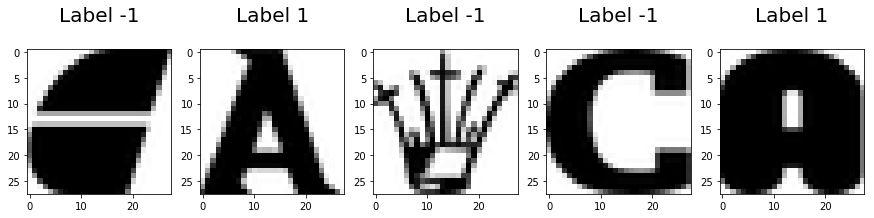

In [47]:
#examples from the dataset
plt.figure(figsize=(15,10))
for index, (image, label) in enumerate(zip(train_data[0:5], train_labels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image.reshape(28,28), cmap='binary')
    plt.title('Label %i\n' % label, fontsize = 20)

## Proximal Gradient Descent (ISTA) and Gradient Descent

<div markdown=1 class="Algo"> ISTA algorithm

* Initialization: Start at point $\theta^0$, Lipschitz constant L>0. 
* For k = 1,2 ... until convergence
    * $\theta^k = prox_{\lambda||\cdot||_1/L} (\theta^{k-1}-\frac{1}{L}\nabla f(\theta^{k-1}))$
* Return last $\theta^k$

<div markdown=1 class="Def"> Proximal operator. 

For any convex function $g$ we define it's proximal operator as:
$$
\text{prox}_g(y) = \text{argmin}_{x\in\mathbb{R}^d} \left\{\frac{1}{2} || x - y ||_2^2 + g(x) \right\}
$$

<div markdown=1 class="Rmk"> From the lecture we know that:
$$
\text{prox}_{\lambda ||\cdot||_1 (y)} = S_\lambda(y) = \text{sign}(y) \cdot (|y| - \lambda)_+
$$

In [48]:
def gradf(ID, x, y, theta, lambd):
    def sigmoid(z):
        return np.exp(z) / (1 + np.exp(z))
    s = -y * (x@theta.T)
    grad = - 1/len(y) * (sigmoid(s) * y.T) @ x
    if ID == 'l1': 
        return grad
    elif ID == 'l2':
        return grad + 2 * lambd * theta
    else:
        raise ValueError

In [49]:
def error(theta, data, labels): 
    #computes the error by rounding the results
    E = data@theta.T
    acc = 0
    for x,y in zip(E, labels):
        if x > 0 and y == 1: acc += 1 
        elif x < 0 and y== -1: acc += 1
    # acc # error
    return 1 - acc/len(labels)

In [50]:
# LASSO with ISTA
def positivize(A):
    A[A < 0] = 0
    return A

def soft_thresholding(x, l):
    return np.sign(x)*positivize(np.abs(x) - l)

def prox(coef, x):
    return soft_thresholding(x, coef)

def ISTA(itheta, x, y, L, lambd, max_iterations = 500):
    theta = itheta
    for _ in range(max_iterations):
        theta = prox(lambd/L, theta - (1/L) *  gradf('l1', x, y, theta, lambd))
    return theta

# RIDGE with GD
def gradient_descent(itheta, x, y, lambd, max_iterations = 500 ,eta = 1e-3):
    theta = itheta
    for _ in range(max_iterations):
        theta = theta - eta * gradf('l2', x, y, theta, lambd)
    return theta

### Results

In [51]:
# parameters
L = np.max([np.linalg.norm(xi)**2 for xi in train_data])
lambdas_lasso = np.linspace(0, 1e-1)

lambdas_ridge = np.linspace(0, 20)

In [52]:
print("Loading lasso errors...")

l_err_train, l_err_test, lthetas = [], [], [] 

for l in lambdas_lasso:
    theta = ISTA(np.random.random_sample(train_data.shape[1])*1e-5, train_data, train_labels, L, l)
    lthetas.append(theta)
    l_err_train.append(error(theta, train_data, train_labels))
    l_err_test.append(error(theta, test_data, test_labels))
    
print("Done. Loading ridge errors...")

r_err_train, r_err_test, rthetas = [], [], []

for l in lambdas_ridge:
    theta = gradient_descent(np.random.random_sample(train_data.shape[1])*1e-5, train_data, train_labels, l)
    rthetas.append(theta)
    r_err_train.append(error(theta, train_data, train_labels))
    r_err_test.append(error(theta, test_data, test_labels))
    
print("Done.")

Loading lasso errors...
Done. Loading ridge errors...
Done.


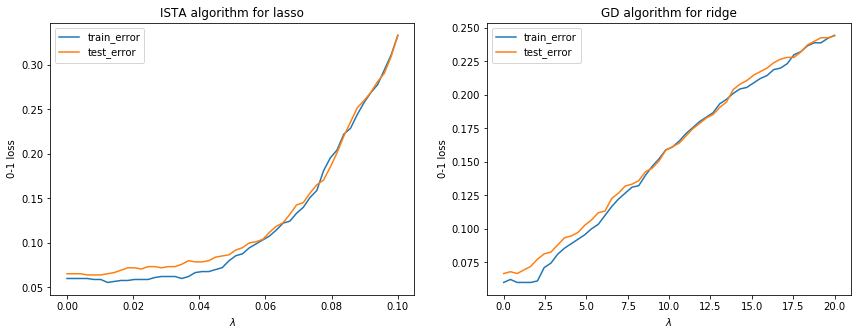

In [53]:
#plots
plt.figure(figsize=(30,5))
plt.subplot(1,4,1)
plt.plot(lambdas_lasso, l_err_train, label = 'train_error')
plt.plot(lambdas_lasso, l_err_test, label = 'test_error')
plt.xlabel('$\lambda$')
plt.ylabel('0-1 loss')
plt.title('ISTA algorithm for lasso')
plt.legend()

plt.subplot(1,4,2)
plt.plot(lambdas_ridge, r_err_train, label = 'train_error')
plt.plot(lambdas_ridge, r_err_test, label = 'test_error')
plt.xlabel('$\lambda$')
plt.ylabel('0-1 loss')
plt.title('GD algorithm for ridge')
plt.legend()
plt.show()

### Best    $\lambda$

In [71]:
# cross validation to find the best lambda

def K_fold(n_splits, ID, x, y, lambd, L):
    test_error = []
    for i in range(0, n_splits):
        d = int(len(x) / n_splits) 
        tests_x = np.array(x[i*d: (i+1)*d])
        tests_y = np.array(y[i*d: (i+1)*d])
        trains_x = np.concatenate([x[:i*d], x[(i+1)*d:]])
        trains_y = np.concatenate([y[:i*d], y[(i+1)*d:]])
        if ID=="l1":
            theta = ISTA(np.random.random_sample(train_data.shape[1])*1e-5, train_data, train_labels, L, l, 
                         max_iterations = 500)
        elif ID=="l2":
            theta = gradient_descent(np.random.random_sample(train_data.shape[1])*1e-5, train_data, train_labels, l,
                                     max_iterations = 500)
        else: 
            raise ValueError
        test_error.append(error(theta, tests_x, tests_y))
    e = np.sum(test_error)/len(test_error)
    #print("Best err: {} for l: {} ".format(e, lambd))
    return e

In [ ]:
lambdas_lasso2 = np.linspace(0, 0.1)
lambdas_ridge2 = np.linspace(0, 6)

r_err , l_err = [], []
n_splits = 5
print("Loading K_fold lasso..")
for l in lambdas_lasso2:
    l_err.append(K_fold(n_splits, 'l1', train_data, train_labels, l, L))
print("Done. Loading K_fold ridge...")
for l in lambdas_ridge2:
    r_err.append(K_fold(n_splits, 'l2', train_data, train_labels, l, L))
print("Done.")

In [73]:

title = ["Best lambda-Kfold ", " Error "] 
title2 = ["L1", "L2"]
data = [[lambdas_lasso2[np.argmin(l_err)], min(l_err), lambdas_lasso[np.argmin(l_err_train)], 
        min(l_err_train),lambdas_lasso[np.argmin(l_err_test)], min(l_err_test)],
       [lambdas_ridge2[np.argmin(r_err)], min(l_err), lambdas_ridge[np.argmin(r_err_train)], 
        min(r_err_train),lambdas_ridge[np.argmin(r_err_test)], min(r_err_test)]]

format_row = "{:<25}" * (len(title) + 1)
print(format_row.format("Norm",*title))
print("====="*(len(title[0])))
for team, row in zip(title2, data):
    print(format_row.format(team, *row))

Norm                     Best lambda-Kfold         Error                   
L1                       0.012244897959183675     0.05555555555555554      
L2                       1.1020408163265305       0.05555555555555554      


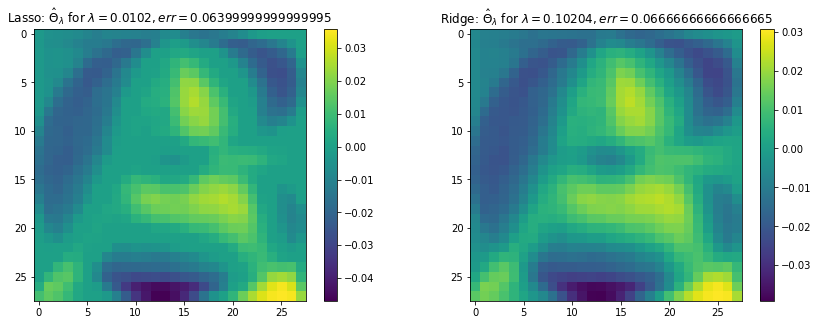

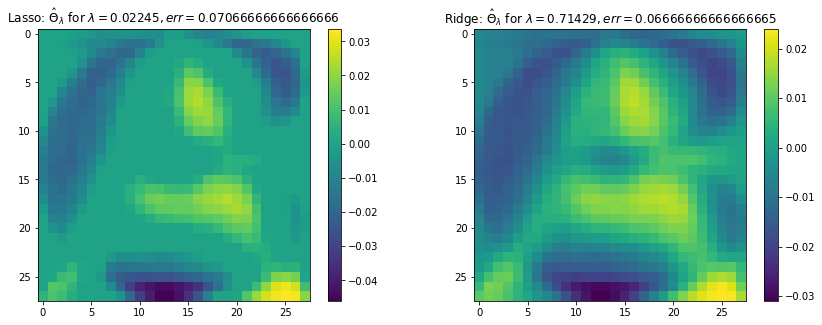

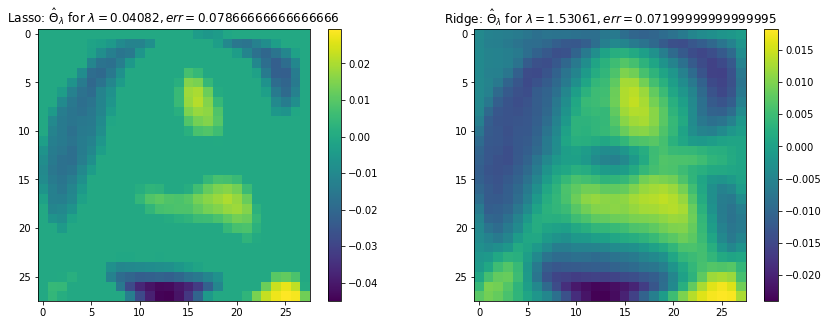

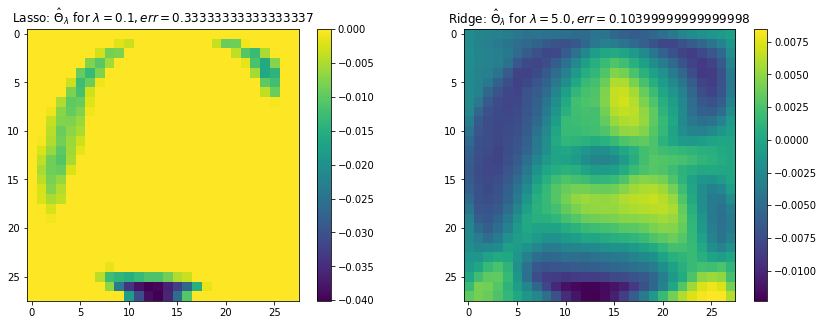

In [127]:
# plot 4 images for estimator

ll = [5, 11, 20, -1]

lr = [1, 7, 15, -1]

for l,r in zip(ll,lr):
    plt.figure(figsize = (30,5))
    plt.subplot(1,4,1)
    image = lthetas[l]
    plt.imshow(image.reshape(28,28))
    plt.colorbar()
    plt.title("Lasso: $\hat\Theta_\lambda$ for $\lambda ={}, err ={}$".format(
        np.round(lambdas_lasso[l],5), l_err_test[l]))
    plt.subplot(1,4,2)
    image = rthetas[r]
    plt.imshow(image.reshape(28,28))
    plt.colorbar()
    plt.title("Ridge: $\hat\Theta_\lambda$ for $\lambda ={}, err ={}$".format(
        np.round(lambdas_ridge[r],5), r_err_test[r]))
    plt.show()


## LDA

In [132]:
def init_LDA(x, y, lambd = 0.07906043210907697):
    n = x.shape[0] # nb_of data points
    nb_features = x.shape[1]
    classes, class_to_index = np.unique(y, return_inverse = True)
    nb_classes  = len(classes)
    
    pi = np.array([np.sum(y == -1)/n, np.sum(y == 1)/n])

    #mu = [sum(x[y == cat]) for cat in classes]
    
    mu = np.zeros((nb_classes, nb_features))
    for i in range(n):
        mu[class_to_index[i]] += x[i,:]
    mu /= pi[:, None]
    mu /= n
    
    sigma = np.zeros((x.shape[1], x.shape[1]))
    
    for idx, cat in enumerate(classes):
        xg_centered = x[y == cat, :] - mu[idx, :]
        sigma += pi[idx]*np.cov(xg_centered.T)
    
    sigma += lambd*np.diag(np.ones(sigma.shape[0]))
        
    St = np.cov(x.T, bias = 1)
    
    return pi, mu, sigma, St

def find_beta(pi, mu, sigma, St):
    Sw = sigma 
    Sb = St - Sw
    
    eigenvals, eigenvecs = linalg.eigh(Sb, Sw)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    beta = np.dot(mu, eigenvecs).dot(eigenvecs.T)
    beta0 = (-0.5 * np.diag(np.dot(mu, beta.T)) +
                       np.log(pi))
    beta0 = beta0[1] - beta0[0]
    beta = beta[1,:] - beta[0, :]
    return beta0, beta


In [133]:
def classify(x, b0, b):
    exponent = np.dot(x, b.T) + b0
    def sigmoid(z):
        return 1/(1 + np.exp(-z))
    proba = sigmoid(exponent)
    proba = proba.flatten()
    return 2*(proba>0.5)-1

def score(x, y, b0, b):
    predicted_labels = classify(x, b0, b)
    return (sum(predicted_labels == y)/len(y))
    
def run_check(data, labels, b0, b, name = 'test'):
    predicted_labels = classify(data, b0, b)

    print('Accuracy of {}%'.format(score(data, labels, b0, b)*100))

    cm = confusion_matrix(labels, predicted_labels)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix on {} data'.format(name)) 
    ax.xaxis.set_ticklabels(['B/C', 'A']) 
    ax.yaxis.set_ticklabels(['B/C', 'A'])
    plt.show()

Accuracy of 98.0%


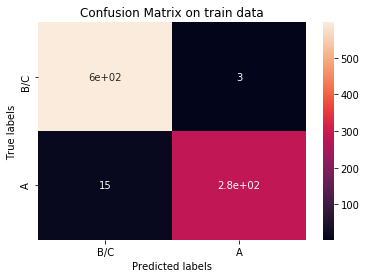

Accuracy of 94.8%


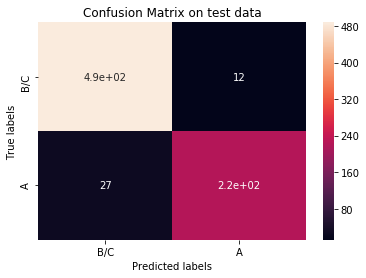

In [134]:
pi, mu, sigma, St = init_LDA(train_data, train_labels)
beta0, beta = find_beta(pi, mu, sigma, St)
run_check(train_data, train_labels, beta0, beta, 'train')
run_check(test_data, test_labels, beta0, beta, 'test')

### Differ $\lambda$

In [61]:
err_test = []
err_train = []
tab = np.logspace(-3,0)

for l in tab:
    pi, mu, sigma, St = init_LDA(train_data, train_labels, lambd = l)
    beta0, beta = find_beta(pi, mu, sigma, St)
    err_test.append(1-score(test_data, test_labels, beta0, beta))
    err_train.append(1-score(train_data, train_labels, beta0, beta))

Optimal lambda = 0.07906043210907697


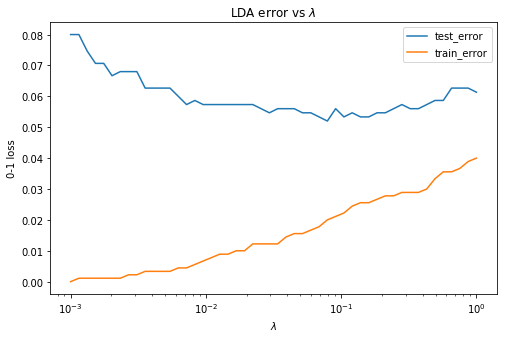

In [70]:
print('Optimal lambda = {}'.format(tab[np.argmin(err_test)]))

plt.figure(figsize=(8,5))
plt.xlabel('$\lambda$')
plt.ylabel('0-1 loss')
plt.semilogx(tab, err_test, label = 'test_error')
plt.semilogx(tab, err_train, label = 'train_error')
plt.title("LDA error vs $\lambda $")
plt.legend()
plt.show()

## Unsupervised Learning

In [74]:
def load_data2():
    print("Loading images...")
    df_train = pd.DataFrame()
    data, labels = [], []
    imgpath = sorted(list(paths.list_images("./data2")))
    random.seed(time.time())
    random.shuffle(imgpath)
    for ipath in imgpath:
        image = cv2.imread(ipath,0)
        image = image.astype('float32') / 255
        tmp2 = ipath.split(os.path.sep)[-2]
        #perhaps normalize the set X
        data.append(image.flatten())
        if tmp2 == "A": 
            labels.append(0)
        elif tmp2 == "B":
            labels.append(1)
        else:
            labels.append(2)
    print("Loading dataset done.")   
    return np.array(data),  np.array(labels)

In [75]:
data, labels = load_data2()
print("Total images: ", data.shape)

Loading images...
Loading dataset done.
Total images:  (1650, 784)


### Re-define the dataset

$\mathcal{Y} \in \{0,1,2\}$ where $Y_i = 0$ if image is $"A"$, $Y_i = 1$ if image is $"B"$, $Y_i = 2$ if image is $"C"$.

Total images:  (1650, 784)
Shape of the images/ Number of features:  784


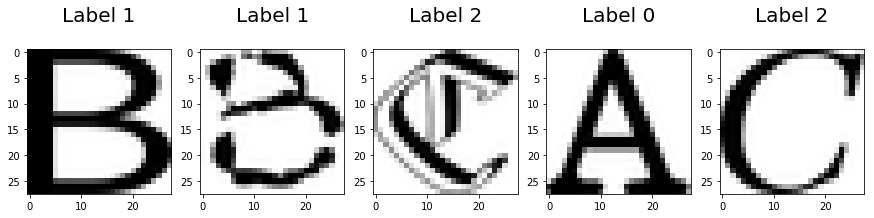

In [76]:
print("Total images: ", data.shape)
print("Shape of the images/ Number of features: ", data[0].shape[0])
#examples from the dataset
plt.figure(figsize=(15,10))
for index, (image, label) in enumerate(zip(data[0:5], labels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image.reshape(28,28), cmap='binary')
    plt.title('Label %i\n' % label, fontsize = 20)

### K-Means 

In [78]:
def euclid_dist(x,y):
    return (np.sum((x - y)**2, axis=1))**0.5

def k_means(data, labels, k, max_iter = 500):
    centroids = data[:k]
    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]
        labels_clusters = [[] for _ in range(k)]
        for value,label in zip(data,labels):
            c = np.argmin(euclid_dist(value, centroids))
            clusters[c].append(value)
            labels_clusters[c].append(label)
        tmp = []
        for cl in clusters:
            tmp.append((sum(cl)/len(cl)))
        centroids = tmp
    return centroids, clusters, labels_clusters

def find_label(cluster):
    poss = [0, 1, 2]
    counts = [cluster.count(i) for i in poss]
    label = poss[np.argmax(counts)]
    err = sum(counts) - counts[label]
    return label, err

def kmeans_error(labels_clusters):
    errs = [find_label(c)[1] for c in labels_clusters]
    return sum(errs) 

def k_means_init(n_init, data, labels, k, max_iter = 100):
    best_centrois, best_clusters, best_labels_clusters, best_err = None, None, None, np.inf
    for i in range(n_init):
        print('Starting {}th iteration'.format(i))
        tab = np.arange(len(data))
        np.random.shuffle(tab)
        centroids, clusters, labels_clusters = k_means(data[tab], labels[tab], k, max_iter)
        err = kmeans_error(labels_clusters)
        if err < best_err:
            best_centrois, best_clusters, best_labels_clusters = centroids, clusters, labels_clusters
            best_err = err
        print('Done. error: ', err/len(data))
    print('Best error found is: ', best_err/len(data))
    return best_centrois, best_clusters, best_labels_clusters, best_err/len(data)


In [79]:
#run kmeans with n_init = 10
centroids, clusters, labels_clusters, best_err = k_means_init(10, data, labels, 3)

Starting 0th iteration
Done. error:  0.21696969696969698
Starting 1th iteration
Done. error:  0.21696969696969698
Starting 2th iteration
Done. error:  0.21696969696969698
Starting 3th iteration
Done. error:  0.21696969696969698
Starting 4th iteration
Done. error:  0.21696969696969698
Starting 5th iteration
Done. error:  0.22363636363636363
Starting 6th iteration
Done. error:  0.2193939393939394
Starting 7th iteration
Done. error:  0.21696969696969698
Starting 8th iteration
Done. error:  0.21696969696969698
Starting 9th iteration
Done. error:  0.21696969696969698
Best error found is:  0.21696969696969698


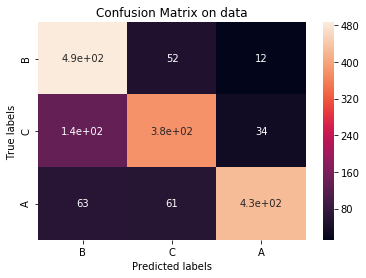

In [80]:
# Confusion Matrix

corr_labels = [find_label(labels_clusters[i])[0] for i in range(3)]
letters = np.array(['A', 'B', 'C'])

predicted_labels = [corr_labels[0]]*len(clusters[0]) + [corr_labels[1]]*len(clusters[1]) + [corr_labels[2]]*len(clusters[2])

real_labels = []
for i in range(3):
    real_labels += labels_clusters[i]

cm = confusion_matrix(real_labels, predicted_labels)

#plot
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix on data') 
ax.xaxis.set_ticklabels(letters[corr_labels]) 
ax.yaxis.set_ticklabels(letters[corr_labels])
plt.show()

In [111]:
def pca(central, data, n_components = 2):
    n,m = data.shape
    #print('Data shape: ', data.shape)
    mean = data.mean(axis=0)
    #print(mean.shape)
    if central: # central data to make the clusters look distinct
        data = data - mean
    CovarianceMatrix = (data.T @ data)/(n-1)
    eigenvalues, eigenvectors = np.linalg.eig(CovarianceMatrix)
    descending_order = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[descending_order]
    eigenvectors = eigenvectors[:, descending_order]
    eigenvalues = eigenvalues[0:n_components]
    eigenvectors = eigenvectors[:, 0:n_components]
    return data @ eigenvectors

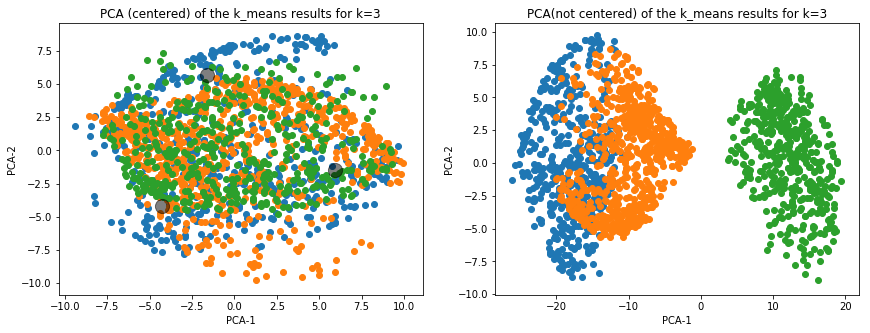

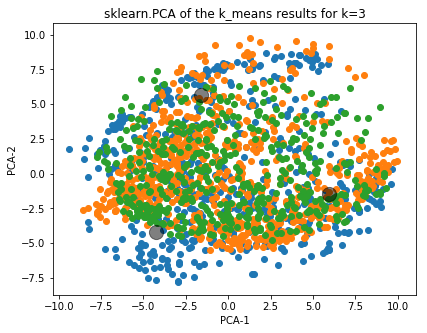

In [112]:
#run pca on clusters
plt.figure(figsize=(30, 5))
plt.subplot(1,4,1)
plt.title("PCA (centered) of the k_means results for k=3")
for c in clusters:
    p = pca(1, np.array(c))
    plt.scatter(p[:,0], p[:,1])
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
p = pca(1,np.array(centroids))    
plt.scatter(p[:,0], p [:,1], color = 'black', s=200, alpha=0.5)

plt.subplot(1,4,2)
plt.title("PCA(not centered) of the k_means results for k=3")
for c in clusters:
    p = pca(0, np.array(c))
    plt.scatter(p[:,0], p[:,1])
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()

#pca from sklearn 
plt.figure(figsize=(30, 5))
plt.subplot(1,4,1)
pca2 = PCA(n_components=2)
p1 = pca2.fit_transform(clusters[0])
p2 = pca2.fit_transform(clusters[1])
p3 = pca2.fit_transform(clusters[2])
plt.scatter(p1[:,0], p1[:,1])
plt.scatter(p2[:,0], p2[:,1])
plt.scatter(p3[:,0], p3[:,1])
plt.title("sklearn.PCA of the k_means results for k=3")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
p = pca2.fit_transform(np.array(centroids))    
plt.scatter(p[:,0], p [:,1], color = 'black', s=200, alpha=0.5)
plt.show()


# The End